In [1]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import feature_importance_permutation
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC
import gc; gc.enable()

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [36]:
df = pd.read_csv('clean_data.csv')

In [37]:
pd.options.display.max_columns=100
df

,Unnamed: 0,status_group,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,decade,installer_cat,funder_cat
0,0,0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,90s,Others,Others
1,1,0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,10s,Others,Others
2,2,0,Lottery Club,686,world vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,00s,world vision,Others
3,3,2,Unicef,263,Unicef,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,80s,Others,Unicef
4,4,0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,2000,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,0,Others,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,59395,0,Germany Republi,1210,CES,37.169807,-3.253847,Pangani,Kilimanjaro,5,Hai,Masama Magharibi,125,True,True,1999,gravity,water board,pay per bucket,soft,enough,spring,communal standpipe,90s,Others,Germany Republi
59396,59396,0,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Rufiji,Iringa,4,Njombe,Ikondo,56,True,True,1996,gravity,vwc,pay annually,soft,enough,river,communal standpipe,90s,Others,Others
59397,59397,0,Unknown,0,Unknown,34.017087,-8.750434,Rufiji,Mbeya,7,Mbarali,Chimala,281,True,False,2000,swn 80,vwc,pay monthly,fluoride,enough,machine dbh,hand pump,0,Unknown,Unknown
59398,59398,0,Malec,0,Musa,35.861315,-6.378573,Rufiji,Dodoma,4,Chamwino,Mvumi Makulu,281,True,True,2000,nira/tanira,vwc,never pay,soft,insufficient,shallow well,hand pump,0,Others,Others


In [38]:
df.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True )

In [39]:
df1 = df.copy()

In [40]:
df1.drop(columns=['lga','ward'],inplace=True )

In [41]:
df1['permit'] = df1['permit'].astype(bool).astype(int)

In [42]:
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int)

<h4> Devide columns

In [43]:
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','installer_cat','funder_cat']
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [44]:
df1['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [45]:
target_status_group = {0:1, 1: 1, 2 : 0}
df1['status_group'] = df1['status_group'].replace(target_status_group)

In [46]:
df1['status_group'].value_counts()

1    36576
0    22824
Name: status_group, dtype: int64

In [47]:
target='status_group'

In [48]:
used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
scaler = MinMaxScaler()

encoder = ce.OneHotEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])
# choosing model
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

0.8541299678940515 +/- 0.0023428488219947394
Accuracy:
TRAIN: 0.7920454545454545
TEST: 0.7913299663299663

Balanced Accuracy:
TRAIN: 0.7771112178577407
TEST: 0.7758141223726345


In [35]:
scaler = MinMaxScaler()

encoder = ce.OneHotEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])
# choosing model
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                            random_state=42, class_weight='balanced')

pipe = make_pipeline(preprocessor,dt)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

0.7632995489842811 +/- 0.006053885098235227
Accuracy:
TRAIN: 0.7699705387205387
TEST: 0.7658249158249159

Balanced Accuracy:
TRAIN: 0.714545057186272
TEST: 0.710496317270686


In [55]:
scaler = MinMaxScaler()

encoder = ce.OneHotEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])
# choosing model
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1,class_weight='balanced')

pipe = make_pipeline(preprocessor,rf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

0.9178164853628958 +/- 0.002193828049456028
Accuracy:
TRAIN: 0.9986321548821548
TEST: 0.857912457912458

Balanced Accuracy:
TRAIN: 0.9985699388552072
TEST: 0.8421339573932569


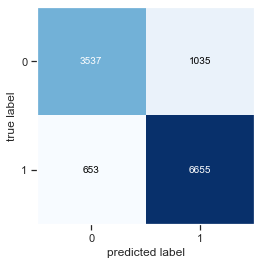

In [56]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

<h4> Grid Search

Feature ranking:
1. feature 2 (0.127961)
2. feature 1 (0.125233)
3. feature 80 (0.087601)
4. feature 0 (0.065935)
5. feature 4 (0.046230)
6. feature 78 (0.031500)
7. feature 39 (0.030652)
8. feature 94 (0.030289)
9. feature 3 (0.023014)
10. feature 63 (0.017525)
11. feature 77 (0.013857)
12. feature 92 (0.012523)
13. feature 51 (0.010181)
14. feature 37 (0.009655)
15. feature 128 (0.009597)
16. feature 93 (0.009562)
17. feature 6 (0.009357)
18. feature 101 (0.008896)
19. feature 123 (0.008796)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

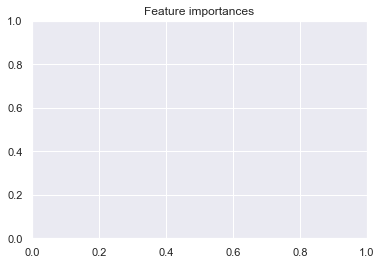

In [60]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X1.shape[1]), indices)
plt.xlim([-1, X1.shape[1]])
plt.show()